In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *

Using TensorFlow backend.


In [3]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "7"
set_session(tf.Session(config=config))

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
# convert data to numpy arrays
X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 921
Number of healthy controls: 464
Number of AD patients: 457


In [11]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [12]:
# images are already masked
mask = None

# Model

In [13]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

In [14]:
files_train = np.array(files_train)

In [15]:
names_train = [item[53:53+10].decode('utf-8') for item in files_train]

### Normalize min-max

In [16]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel and split data

In [17]:
GSS = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

mean = np.mean(X_train[train_idx], axis=0)
std = np.std(X_train[train_idx], axis=0)
X_train = (X_train - mean) / (std)

# Training

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 31s 41ms/step - loss: 2.0042 - acc: 0.4967 - val_loss: 1.6632 - val_acc: 0.5864
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.5699 - acc: 0.5494 - val_loss: 1.3109 - val_acc: 0.6790
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2836 - acc: 0.6258 - val_loss: 1.0372 - val_acc: 0.7469
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9936 - acc: 0.7036 - val_loss: 0.9616 - val_acc: 0.7222
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8383 - acc: 0.7734 - val_loss: 0.8210 - val_acc: 0.7222
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8457 - acc: 0.7602 - val_loss: 0.8846 - val_acc: 0.6667
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8096 - acc: 0.7325 - val_loss: 0.7185 - val_acc: 0.7346
Epoch 8/45
759/7

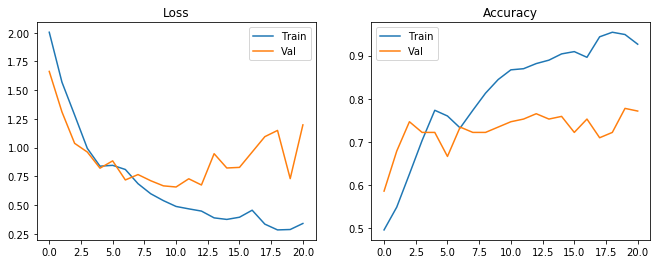

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 38ms/step - loss: 1.9959 - acc: 0.5152 - val_loss: 1.6774 - val_acc: 0.5123
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.6311 - acc: 0.5560 - val_loss: 1.4306 - val_acc: 0.5000
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2960 - acc: 0.6271 - val_loss: 1.1016 - val_acc: 0.7654
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0016 - acc: 0.7497 - val_loss: 0.9495 - val_acc: 0.7346
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8744 - acc: 0.7497 - val_loss: 0.8617 - val_acc: 0.7284
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9010 - acc: 0.7431 - val_loss: 0.8006 - val_acc: 0.7593
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7222 - acc: 0.7918 - val_loss: 0.8089 - val_acc: 0.7407
Epoch 8/45
759/7

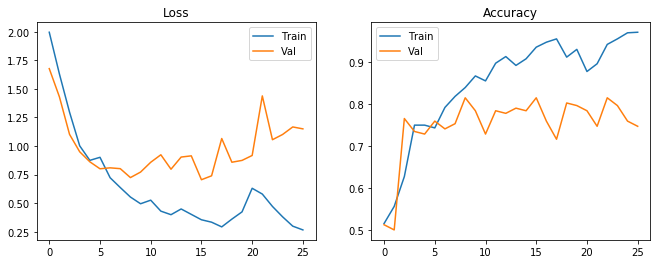

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 38ms/step - loss: 2.0224 - acc: 0.5086 - val_loss: 1.7682 - val_acc: 0.5062
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.7813 - acc: 0.4888 - val_loss: 1.4279 - val_acc: 0.6667
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.3413 - acc: 0.6166 - val_loss: 1.1643 - val_acc: 0.6790
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0844 - acc: 0.6877 - val_loss: 0.9796 - val_acc: 0.7531
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9138 - acc: 0.7391 - val_loss: 0.8227 - val_acc: 0.8025
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7663 - acc: 0.7826 - val_loss: 0.7779 - val_acc: 0.8086
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7609 - acc: 0.7589 - val_loss: 0.7872 - val_acc: 0.7531
Epoch 8/45
759/7

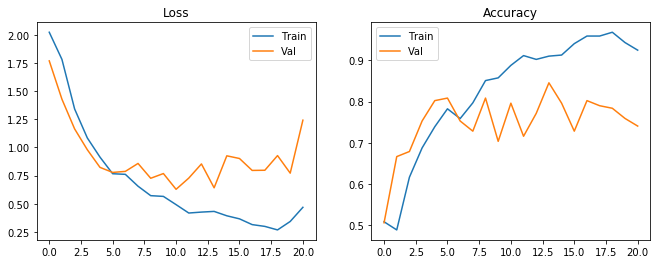

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 38ms/step - loss: 2.1423 - acc: 0.5099 - val_loss: 1.8301 - val_acc: 0.4938
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.7037 - acc: 0.5784 - val_loss: 1.4262 - val_acc: 0.7160
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.4524 - acc: 0.6113 - val_loss: 1.2522 - val_acc: 0.6667
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.1415 - acc: 0.6851 - val_loss: 0.9452 - val_acc: 0.7963
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9221 - acc: 0.7655 - val_loss: 0.8534 - val_acc: 0.7778
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7812 - acc: 0.7852 - val_loss: 0.9237 - val_acc: 0.7901
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7653 - acc: 0.7918 - val_loss: 0.8115 - val_acc: 0.7407
Epoch 8/45
759/7

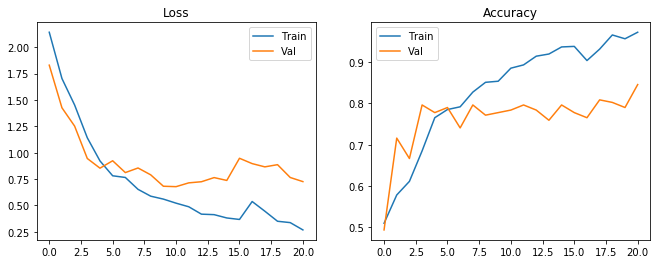

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 38ms/step - loss: 1.9614 - acc: 0.4875 - val_loss: 1.6221 - val_acc: 0.6296
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.5363 - acc: 0.5744 - val_loss: 1.2891 - val_acc: 0.6481
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2171 - acc: 0.6864 - val_loss: 1.1096 - val_acc: 0.6173
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0828 - acc: 0.7101 - val_loss: 0.9768 - val_acc: 0.6852
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8830 - acc: 0.7655 - val_loss: 0.8046 - val_acc: 0.7654
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7598 - acc: 0.7708 - val_loss: 0.7882 - val_acc: 0.7654
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7223 - acc: 0.7813 - val_loss: 0.8084 - val_acc: 0.7346
Epoch 8/45
759/7

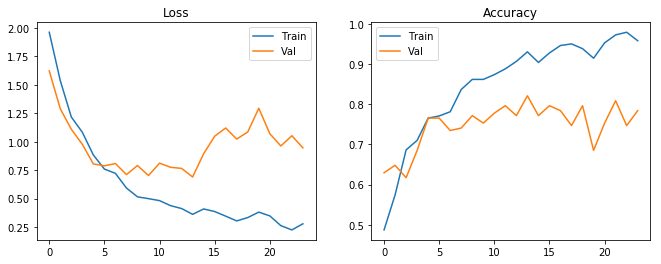

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 39ms/step - loss: 1.9601 - acc: 0.5415 - val_loss: 1.6119 - val_acc: 0.6481
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.5403 - acc: 0.6153 - val_loss: 1.2690 - val_acc: 0.7593
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2233 - acc: 0.6983 - val_loss: 1.4889 - val_acc: 0.5432
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0336 - acc: 0.7220 - val_loss: 0.8679 - val_acc: 0.8025
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8310 - acc: 0.7879 - val_loss: 0.7924 - val_acc: 0.7531
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7410 - acc: 0.7997 - val_loss: 0.9476 - val_acc: 0.6852
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.6877 - acc: 0.7958 - val_loss: 0.7279 - val_acc: 0.7593
Epoch 8/45
759/7

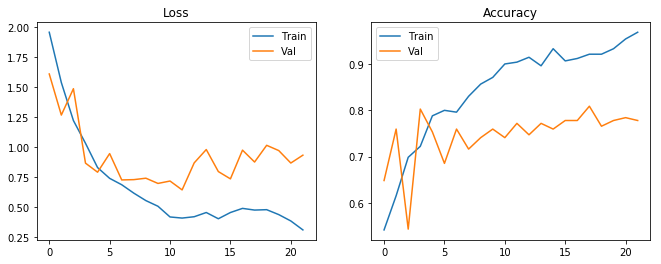

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 38ms/step - loss: 2.0198 - acc: 0.5152 - val_loss: 1.6726 - val_acc: 0.7284
Epoch 2/45
759/759 [==============================] - 28s 36ms/step - loss: 1.5990 - acc: 0.6548 - val_loss: 1.4810 - val_acc: 0.5741
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.3652 - acc: 0.6298 - val_loss: 1.1806 - val_acc: 0.6852
Epoch 4/45
759/759 [==============================] - 26s 34ms/step - loss: 1.0723 - acc: 0.7167 - val_loss: 0.9532 - val_acc: 0.7346
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9202 - acc: 0.7721 - val_loss: 0.8121 - val_acc: 0.7963
Epoch 6/45
759/759 [==============================] - 26s 34ms/step - loss: 0.8038 - acc: 0.7852 - val_loss: 1.0585 - val_acc: 0.6605
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.6886 - acc: 0.8076 - val_loss: 1.0764 - val_acc: 0.6296
Epoch 8/45
759/7

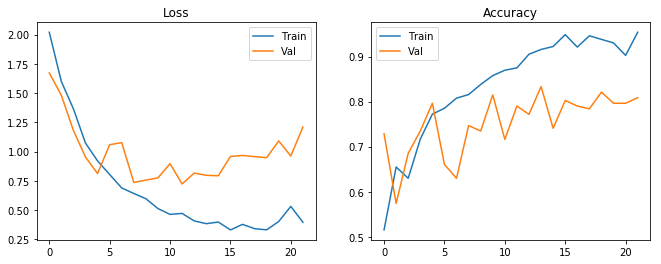

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 39ms/step - loss: 2.1156 - acc: 0.5072 - val_loss: 1.7155 - val_acc: 0.5062
Epoch 2/45
759/759 [==============================] - 29s 38ms/step - loss: 1.6393 - acc: 0.5837 - val_loss: 1.5186 - val_acc: 0.4938
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.3628 - acc: 0.6232 - val_loss: 1.1794 - val_acc: 0.6975
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0932 - acc: 0.7009 - val_loss: 0.9369 - val_acc: 0.8025
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9386 - acc: 0.7549 - val_loss: 0.8450 - val_acc: 0.7840
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7834 - acc: 0.7892 - val_loss: 0.8019 - val_acc: 0.7531
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.6834 - acc: 0.8024 - val_loss: 0.8051 - val_acc: 0.7222
Epoch 8/45
759/7

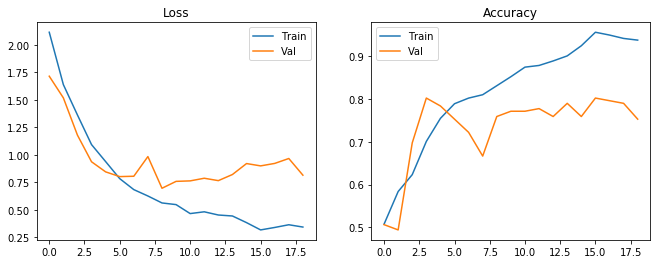

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 32s 42ms/step - loss: 1.9626 - acc: 0.5441 - val_loss: 1.7272 - val_acc: 0.5062
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.6375 - acc: 0.5955 - val_loss: 1.4572 - val_acc: 0.4938
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2805 - acc: 0.6719 - val_loss: 1.2488 - val_acc: 0.6111
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0884 - acc: 0.6943 - val_loss: 0.9078 - val_acc: 0.7963
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.9566 - acc: 0.7273 - val_loss: 0.8808 - val_acc: 0.7469
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8406 - acc: 0.7628 - val_loss: 0.8265 - val_acc: 0.7593
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8433 - acc: 0.7339 - val_loss: 0.7348 - val_acc: 0.7778
Epoch 8/45
759/7

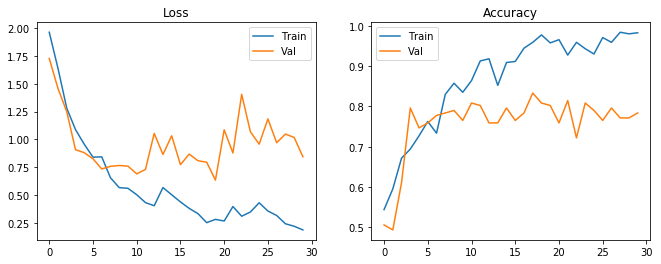

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 29s 39ms/step - loss: 1.9640 - acc: 0.5771 - val_loss: 1.5973 - val_acc: 0.6728
Epoch 2/45
759/759 [==============================] - 28s 37ms/step - loss: 1.5429 - acc: 0.6087 - val_loss: 1.2334 - val_acc: 0.7840
Epoch 3/45
759/759 [==============================] - 28s 37ms/step - loss: 1.2746 - acc: 0.6693 - val_loss: 1.2373 - val_acc: 0.5864
Epoch 4/45
759/759 [==============================] - 28s 37ms/step - loss: 1.0198 - acc: 0.7194 - val_loss: 0.9287 - val_acc: 0.7222
Epoch 5/45
759/759 [==============================] - 28s 37ms/step - loss: 0.8247 - acc: 0.7800 - val_loss: 0.7936 - val_acc: 0.7901
Epoch 6/45
759/759 [==============================] - 28s 37ms/step - loss: 0.7143 - acc: 0.8076 - val_loss: 1.1258 - val_acc: 0.6914
Epoch 7/45
759/759 [==============================] - 28s 37ms/step - loss: 0.6147 - acc: 0.8340 - val_loss: 0.7614 - val_acc: 0.7654
Epoch 8/45
759/7

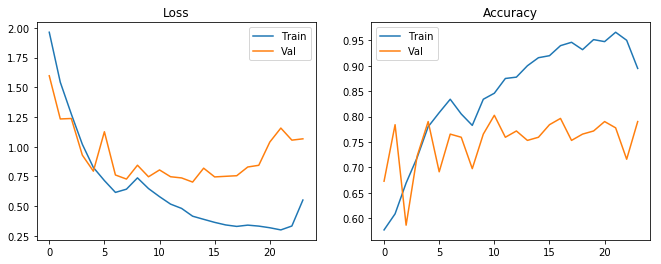

In [18]:
# training args
lr = 0.001
lr_decay = 0.

num_trials = 10
patience = 10
store_models = False

best_acc = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model.h5"), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_train[val_idx],y_train[val_idx]),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    
    best_acc.append(np.max(history.history["val_acc"]))

In [19]:
print("All best val accuracies: {}".format(best_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_acc), np.std(best_acc)))

All best val accuracies: [0.7777777777777778, 0.8148148148148148, 0.845679012345679, 0.845679012345679, 0.8209876543209876, 0.808641975308642, 0.8333333333333334, 0.8024691358024691, 0.8333333333333334, 0.8024691358024691]
Average best validation accuracy over 10 trials: 0.81852 (std: 0.02051)


In [20]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

Training Time: 1.0h:52.0m:6.178950071334839s


In [21]:
np.max(history.history["val_acc"])

0.8024691358024691

In [22]:
quit()